In [220]:
from dotenv import load_dotenv
import os

load_dotenv()

openai_api_key = os.getenv("OPENAI_API_KEY")
tavily_api_key = os.getenv("TAVILY_API_KEY")

# Validate the required API keys
if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found in .env file.")
if not tavily_api_key:
    raise ValueError("TAVILY_API_KEY not found in .env file.")

In [87]:
import pandas as pd
from transformers import pipeline
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import DataFrameLoader
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableParallel, RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain import hub
from langchain_openai import ChatOpenAI
import os
import getpass
import torch
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
from langchain.llms import HuggingFaceHub

In [88]:
def get_reteriver() : 
    import pandas as pd
    ucsc_passage_df = pd.read_csv("passage.csv")
    ucsc_passge_data_loader = DataFrameLoader(ucsc_passage_df, page_content_column="passage")
    ucsc_passage_data = ucsc_passge_data_loader.load()
    text_splitter = CharacterTextSplitter(chunk_size=200, chunk_overlap=50)
    docs = text_splitter.split_documents(ucsc_passage_data)
    embeddings = HuggingFaceEmbeddings()
    db = FAISS.from_documents(docs, embeddings)
    return db.as_retriever()

In [35]:
from typing import List, Annotated, TypedDict
import operator
from langgraph.graph import StateGraph, START, END
from langgraph.constants import Send
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage

import pprint


class RAREState(TypedDict):
    query: str
    cot_candidates: Annotated[List[str], operator.add]  # chain-of-thoughts from agents
    refined_answers: Annotated[List[str], operator.add]  # final answers from each agent
    best_answer: str

class RARE:
    def __init__(self, retriever):
        self.llm = ChatOpenAI(temperature=0.7, model_name="gpt-3.5-turbo")
        self.retriever = retriever
        self.workflow = StateGraph(RAREState)
        self.num_agents = 3  # Can be made configurable
        self.setup_workflow()

    def setup_workflow(self):
        self.workflow.add_node("generate_cots", self.generate_multiple_cots)
        self.workflow.add_node("process_cot", self.process_cot)
        self.workflow.add_node("select_best", self.select_best_answer)

        self.workflow.add_edge(START, "generate_cots")
        self.workflow.add_conditional_edges("generate_cots", self.dispatch_agents, ["process_cot"])
        self.workflow.add_edge("process_cot", "select_best")
        self.workflow.add_edge("select_best", END)

        self.graph = self.workflow.compile()

    def generate_multiple_cots(self, state: RAREState) -> dict:
        base_prompt = (
            f"Query: {state['query']}\n\n"
            "As an independent reasoning agent, devise a multi-step chain-of-thought to answer this question.\n"
            "Structure your output as a numbered list of steps."
        )

        cot_variants = []
        for i in range(self.num_agents):
            perspective = ["focus on academic aspects", "focus on student experience", "focus on logistics and policies"][i % 3]
            prompt = (
                f"You are agent #{i+1}. {base_prompt}\nTry to approach the question differently by emphasizing: {perspective}."
            )
            response = self.llm.invoke([HumanMessage(content=prompt)])
            cot_variants.append(response.content.strip())

        return {"cot_candidates": cot_variants, "refined_answers": []}


    def dispatch_agents(self, state: RAREState):
        return [Send("process_cot", {"cot": cot}) for cot in state["cot_candidates"]]

    def process_cot(self, state: dict) -> dict:
        cot = state["cot"]
        steps = [s.strip() for s in cot.split("\n") if s.strip()]
        refined_answer = ""

        for step in steps:
            step_query_prompt = (
                f"For the reasoning step: '{step}', generate a concise query to retrieve relevant information."
            )
            query_msg = self.llm.invoke([HumanMessage(content=step_query_prompt)])
            query = query_msg.content.strip()
            docs = self.retriever.invoke(query)
            retrieved_text = "\n".join([doc.page_content for doc in docs])

            reasoning_prompt = (
                f"Given the reasoning step: '{step}' and the following documents:\n\n{retrieved_text}\n\n"
                f"Refine this reasoning step or generate a sub-answer."
            )
            refined_msg = self.llm.invoke([HumanMessage(content=reasoning_prompt)])
            refined_answer += refined_msg.content.strip() + "\n"

        return {"refined_answers": [refined_answer.strip()]}

    def select_best_answer(self, state: RAREState) -> dict:
        prompt = (
            "Below are multiple candidate answers to the user query. Evaluate them for factual correctness, completeness, and clarity.\n"
            f"User Query: {state['query']}\n\n"
        )
        for i, ans in enumerate(state["refined_answers"]):
            prompt += f"Answer #{i+1}:\n{ans}\n\n"
        prompt += "Select the best answer and return it only."

        response = self.llm.invoke([HumanMessage(content=prompt)])
        return {"best_answer": response.content.strip()}

    def run(self, query: str):
        initial_state: RAREState = {
            "query": query,
            "cot_candidates": [],
            "refined_answers": [],
            "best_answer": ""
        }
        for output in self.graph.stream(initial_state):
            for key, value in output.items():
                pprint.pprint(f"Output from node '{key}':")
                pprint.pprint(value, indent=2, width=80, depth=None)
            pprint.pprint("\n---\n")




In [ ]:
!pip install faiss-cpu

In [89]:
retriever = get_reteriver()


Created a chunk of size 265, which is longer than the specified 200
Created a chunk of size 1411, which is longer than the specified 200
Created a chunk of size 294, which is longer than the specified 200
Created a chunk of size 395, which is longer than the specified 200
Created a chunk of size 298, which is longer than the specified 200
Created a chunk of size 324, which is longer than the specified 200
Created a chunk of size 470, which is longer than the specified 200
Created a chunk of size 662, which is longer than the specified 200
Created a chunk of size 451, which is longer than the specified 200
Created a chunk of size 245, which is longer than the specified 200
Created a chunk of size 226, which is longer than the specified 200
Created a chunk of size 580, which is longer than the specified 200
Created a chunk of size 1970, which is longer than the specified 200
Created a chunk of size 617, which is longer than the specified 200
Created a chunk of size 312, which is longer t

In [38]:
rare = RARE(retriever)

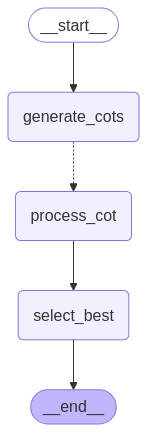

In [39]:
from IPython.display import Image, display

try:
    display(Image(rare.graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [40]:
rare.run("What are the class sizes for the lower and upper division classes under the engineering school?")

"Output from node 'generate_cots':"
{ 'cot_candidates': [ '1. Identify the specific engineering school in question '
                      'to ensure accurate information is gathered. \n'
                      "2. Review the engineering school's official website or "
                      'academic catalog to find information on class sizes for '
                      'lower and upper division classes. \n'
                      '3. Look for sections or pages dedicated to academic '
                      'programs within the engineering school to locate '
                      'details on class sizes. \n'
                      '4. Check the academic requirements or course listings '
                      'for lower division classes (typically freshman and '
                      'sophomore level) to see if class sizes are mentioned. \n'
                      '5. Similarly, examine the requirements or course '
                      'offerings for upper division classes (typically junior 

In [ ]:
## Same flow but now considering the best picked answer documents 

In [215]:
from typing import List, Annotated, TypedDict
import operator
from langgraph.graph import StateGraph, START, END
from langgraph.constants import Send
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage



question_list = []
gen_ans_list = []
searched_docs = []
src_ans_list = []

# Define the state for the RARE framework
class RAREState(TypedDict):
    query: str
    cot_candidates: Annotated[List[str], operator.add]
    refined_answers: Annotated[List[str], operator.add]
    supporting_docs: Annotated[List[List[str]], operator.add]  # NEW
    best_answer: str
    best_docs: List[str]  # NEW

class RARE:
    def __init__(self, retriever):
        self.llm = ChatOpenAI(temperature=0.7, model_name="gpt-3.5-turbo")
        self.retriever = retriever
        self.workflow = StateGraph(RAREState)
        self.num_agents = 3  # Can be made configurable
        self.setup_workflow()

    def setup_workflow(self):
        self.workflow.add_node("generate_cots", self.generate_multiple_cots)
        self.workflow.add_node("process_cot", self.process_cot)
        self.workflow.add_node("select_best", self.select_best_answer)

        self.workflow.add_edge(START, "generate_cots")
        self.workflow.add_conditional_edges("generate_cots", self.dispatch_agents, ["process_cot"])
        self.workflow.add_edge("process_cot", "select_best")
        self.workflow.add_edge("select_best", END)

        self.graph = self.workflow.compile()

    def generate_multiple_cots(self, state: RAREState) -> dict:
        base_prompt = (
            f"Query: {state['query']}\n\n"
            "As an independent reasoning agent, devise a multi-step chain-of-thought to answer this question.\n"
            "Structure your output as a numbered list of steps."
        )

        cot_variants = []
        for i in range(self.num_agents):
            perspective = ["focus on academic aspects", "focus on student experience", "focus on logistics and policies"][i % 3]
            prompt = (
                f"You are agent #{i+1}. {base_prompt}\nTry to approach the question differently by emphasizing: {perspective}."
            )
            response = self.llm.invoke([HumanMessage(content=prompt)])
            cot_variants.append(response.content.strip())

        return {"cot_candidates": cot_variants, "refined_answers": []}


    def dispatch_agents(self, state: RAREState):
        return [Send("process_cot", {"cot": cot}) for cot in state["cot_candidates"]]

    def process_cot(self, state: dict) -> dict:
        cot = state["cot"]
        steps = [s.strip() for s in cot.split("\n") if s.strip()]
        refined_answer = ""

        for step in steps:
            step_query_prompt = (
                f"For the reasoning step: '{step}', generate a concise query to retrieve relevant information."
            )
            query_msg = self.llm.invoke([HumanMessage(content=step_query_prompt)])
            query = query_msg.content.strip()
            docs = self.retriever.invoke(query)
            retrieved_text = "\n".join([doc.page_content for doc in docs])
            

            reasoning_prompt = (
                f"Given the reasoning step: '{step}' and the following documents:\n\n{retrieved_text}\n\n"
                f"Refine this reasoning step or generate a sub-answer."
            )
            refined_msg = self.llm.invoke([HumanMessage(content=reasoning_prompt)])
            refined_answer += refined_msg.content.strip() + "\n"

        return {
    "refined_answers": [refined_answer.strip()],
    "supporting_docs": [[doc.page_content for doc in docs]]
}

    def select_best_answer(self, state: RAREState) -> dict:
        # import re
        # prompt = (
        #     "Below are multiple candidate answers to the user query. Evaluate them for factual correctness, completeness, and clarity.\n"
        #     f"User Query: {state['query']}\n\n"
        # )
        # for i, ans in enumerate(state["refined_answers"]):
        #     prompt += f"Answer #{i+1}:\n{ans}\n\n"
        # prompt += "Select the best answer and return it only."

        # response = self.llm.invoke([HumanMessage(content=prompt)])
        # match = re.search(r"Answer #?(\d+)", response.content)
        # index = int(match.group(1)) - 1 if match else 0
        
        # return {
        #     "best_answer": state["refined_answers"][index],
        #     "best_docs": state["supporting_docs"][index]
        # }
        import re

        # Step 1: Ask the LLM to pick the best candidate
        prompt = (
            "Below are multiple candidate answers to the user query. Evaluate them for factual correctness, completeness, and clarity.\n"
            f"User Query: {state['query']}\n\n"
        )
        
        for i, ans in enumerate(state["refined_answers"]):
            prompt += f"Answer #{i+1}:\n{ans}\n\n"
        prompt += (
    "If NONE of the answers are relevant or meaningful for answering the query, return: Answer #0.\n"
    "Otherwise, pick the best among them and return it as: Answer #<number>.\n"
    "Return ONLY the number in that format. Do NOT include any explanations."
)


    
        response = self.llm.invoke([HumanMessage(content=prompt)])
        match = re.search(r"Answer #?(\d+)", response.content)
        answer_num = int(match.group(1)) if match else 0
        if answer_num == 0:
            return {
                "best_answer": "Sorry, I couldn't find an exact answer. Please check the UCSC website for more information.",
                "best_docs": []
            }
        
        index = answer_num - 1

        # Step 2: Summarize the selected answer into a single fluent output
        raw_cot = state["refined_answers"][index]
    
        summary_prompt = (
        f"The following is a collection of reasoning outputs from various steps that tried to answer the user's question:\n\n"
        f"{raw_cot}\n\n"
        f"Now, write a final, well-structured answer to this query:\n\n"
        f"Query: {state['query']}\n\n"
        "If the reasoning content clearly answers the question, write a complete answer in fluent English.\n"
        "If the content is not sufficient to answer the question directly, write:\n"
        "Avoid the phrase 'Sub-answer'.Also try to give as much as details as possible. Write as if speaking to a student and you are college representative."
    )

    
        summary_msg = self.llm.invoke([HumanMessage(content=summary_prompt)])
        final_answer = summary_msg.content.strip()

        return {
            "best_answer": final_answer,
            "best_docs": state["supporting_docs"][index]
        }

    def run(self, query: str):
        global question_list, gen_ans_list, searched_docs

        initial_state = {
            "query": query,
            "cot_candidates": [],
            "refined_answers": [],
            "supporting_docs": [],
            "best_answer": "",
            "best_docs": []
        }
    
        final_state = None
        for output in self.graph.stream(initial_state):
            final_state = output  # last emitted state from the graph
    
        # Extract from the final node 'select_best'
        select_output = final_state.get("select_best", {})
    
        best_answer = select_output.get("best_answer", "").strip()
        best_docs = select_output.get("best_docs", [])

        if best_answer and best_docs:
            question_list.append(query)
            gen_ans_list.append(best_answer)
            searched_docs.append(best_docs) 
            print(f" Saved answer and docs for: {query}")
        else:
            print(f" Skipped query due to missing answer/docs: {query}")
    
        return {
            "question": query,
            "answer": best_answer,
            "docs": best_docs
        }




In [216]:
rare = RARE(retriever)
rare.run("What classes does the boating center offer to community members?")

 Saved answer and docs for: What classes does the boating center offer to community members?


{'question': 'What classes does the boating center offer to community members?',
 'answer': "The UC Santa Cruz Community Boating Center offers a variety of classes for community members interested in boating. These classes cater to individuals of all skill levels, from beginners to experienced sailors, rowers, and kayakers looking to enhance their abilities on the water. Some of the classes available include sailing lessons, rowing classes, and boating safety courses.\n\nTo find more information about the specific classes offered, you can visit the UC Santa Cruz Community Boating Center website. Look for a section dedicated to programs, classes, or courses, where you can find detailed descriptions of each class, the schedule, duration, and any prerequisites or fees associated with enrollment. If you cannot find the information on the website, feel free to reach out to the boating center via email or phone for more details.\n\nOverall, the UC Santa Cruz Community Boating Center provides

In [156]:
len(gen_ans_list), len(searched_docs), len(question_list)

(1, 1, 1)

In [157]:
gen_ans_list[0], searched_docs[0], question_list[0]

("To find information on class sizes for lower and upper division classes within the engineering school at UC Santa Cruz, you can utilize the Instructional Activity Dashboard provided by the Institutional Research, Analytics, and Planning Support (IRAPS). This tool offers detailed insights into class sizes for different academic divisions and departments at the university. Additionally, reaching out to the engineering school's academic advising office or department chair can give you a better understanding of the typical class sizes for freshman and sophomore (lower division) as well as junior and senior (upper division) engineering courses. If you are unable to find the exact information, I recommend checking the UCSC website for more details.",
 ['A student’s class level plays a large part in how many small classes are available. Introductory classes tend to be large, although they are usually accompanied by required small sections or laboratories. Many small classes have prerequisit

In [217]:
df = pd.read_csv("new_qa.csv")
df.head(10)

,index,questions,answers,source_name,source,generated_response,source_docs
0,0,Who can be a member of the Boating Club?,Everyone is welcome to join! If you do not hav...,UCSC Boating Recreation FQAs,https://recreation.ucsc.edu/boating/faq.html,Members of the Boating Club can include commun...,"Our club exists to give community members, UC ..."
1,1,What classes does the boating center offer to ...,We offer all levels of sailing (dinghy and kee...,UCSC Boating Recreation FQAs,https://recreation.ucsc.edu/boating/faq.html,The boating center offers classes for beginner...,UC Santa Cruz Community Boating Center is a co...
2,2,When is the boating club open?,"The club is open year-round, Saturday and Sund...",UCSC Boating Recreation FQAs,https://recreation.ucsc.edu/boating/faq.html,The boating club is open on Saturday and Sunda...,Boating Club Hours\nThe Community Boating Cent...
3,3,What boats are available to members?,Sailing vessels for weekend use currently incl...,UCSC Boating Recreation FQAs,https://recreation.ucsc.edu/boating/faq.html,Members have access to the following sailing v...,Our boats:\nSailing vessels for weekend use cu...
4,4,How much does a boating membership cost?,UCSC Student Membership: $45\nNon-Student Quar...,UCSC Boating Recreation FQAs,https://recreation.ucsc.edu/boating/faq.html,The provided context does not include any info...,There are a few minor fees associated with tak...
5,5,How do I sign up for a boating membership?,Visit the UC Santa Cruz Recreation website. Cl...,UCSC Boating Recreation FQAs,https://recreation.ucsc.edu/boating/faq.html,The context does not provide specific details ...,Our boats:\nSailing vessels for weekend use cu...
6,6,How can I join the Boating Club?,Come down to the dock during our open club hou...,UCSC Boating Recreation FQAs,https://recreation.ucsc.edu/boating/faq.html,"To join the Boating Club, you need to pay your...","Our club exists to give community members, UC ..."
7,7,Are there additional fees to take out the boat...,There are a few minor fees associated with tak...,UCSC Boating Recreation FQAs,https://recreation.ucsc.edu/boating/faq.html,"Based on the provided context, there are no ad...",There are a few minor fees associated with tak...
8,8,Do the boating club rent Kayaks?,We do not rent our kayaks out to members. Kaya...,UCSC Boating Recreation FQAs,https://recreation.ucsc.edu/boating/faq.html,"No, the boating club does not mention renting ...",Our boats:\nSailing vessels for weekend use cu...
9,9,How can I get involved with the Boating Club?,Ask to join our google group. Here you can rea...,UCSC Boating Recreation FQAs,https://recreation.ucsc.edu/boating/faq.html,"To get involved with the Boating Club, you sho...",Boating Club Hours\nThe Community Boating Cent...


In [194]:
df['answers'][1]

'We offer all levels of sailing (dinghy and keelboats) and rowing classes to community members during the summer. Registration for Summer boating classes opens on March 15th. For questions about course offerings or registration, please call the following number: (831) 425-1164 or (949) 371-1448.'

In [218]:
import pandas as pd
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import faithfulness, answer_relevancy, context_recall, context_precision

# Globals to collect outputs
question_list = []
gen_ans_list = []
searched_docs = []
src_ans_list = []




In [219]:
rare = RARE(retriever)

for i, row in df.iterrows():
    q = row["questions"]
    a = row["answers"]
    print(f"Processing Q{i+1}: {q}")
    src_ans_list.append(a)
    rare.run(q)




Processing Q1: Who can be a member of the Boating Club?
 Saved answer and docs for: Who can be a member of the Boating Club?
Processing Q2: What classes does the boating center offer to community members?



KeyboardInterrupt



In [202]:
len(gen_ans_list), len(searched_docs), len(question_list) , len( src_ans_list)


(113, 113, 113, 112)

In [197]:
gen_ans_list[0], searched_docs[0], question_list[0], src_ans_list[0]

('The UC Santa Cruz Community Boating Center offers a variety of classes for community members interested in sailing, rowing, and kayaking. These classes cater to individuals of all skill levels, from beginners looking to learn new skills to experienced boaters wanting to improve their abilities on the water. The center provides a supportive and vibrant environment for individuals to connect with others who share a passion for water sports and enjoy the beauty of the Monterey Bay. Additionally, the Boating Center offers weekend use of various sailboats and rowing vessels, as well as access to a fleet of sailing vessels, rowing shells, and kayaks for members to use during designated club hours under the supervision of the dockmaster. To get more information on specific classes and programs offered, I recommend reaching out to the Boating Center directly through email or phone to inquire about enrollment dates and opportunities available.',
 ["UC Santa Cruz Community Boating Center is a 

In [204]:
gen_ans_list[2], searched_docs[1], question_list[1], src_ans_list[1]

('The UC Santa Cruz Community Boating Center offers a variety of classes for community members interested in recreational boating activities on the Monterey Bay. These classes cater to individuals of all skill levels, from beginners looking to learn the basics of sailing, rowing, or kayaking, to experienced participants seeking to enhance their skills and knowledge on the water. The center provides opportunities to learn from experienced staff and veteran participants, ensuring a safe and enjoyable experience while exploring the beauty of the bay. Additionally, participants may have the chance to earn certifications or academic recognition through these classes, further enhancing their expertise in water sports. Overall, the boating center offers a comprehensive range of classes to meet the diverse interests and skill levels of community members looking to engage in boating activities.',
 ['How can I join the Boating Club?',
  'The boating club exists to give community members, UC Sant

In [209]:
# print( '1', gen_ans_list[1])  
print('2', question_list[2])
# print('3', src_ans_list[1])
# print('4', searched_docs[1]) 

2 What classes does the boating center offer to community members?


In [75]:
type(searched_docs)

list

In [198]:
filtered_questions = []
filtered_gen_answers = []
filtered_ground_truths = []
filtered_contexts = []
FALLBACK_TEXT = "Sorry, I couldn't find an exact answer"

for q, a, gt, ctx in zip(question_list, gen_ans_list, src_ans_list, searched_docs):
    if not a.startswith(FALLBACK_TEXT):
        filtered_questions.append(q)
        filtered_gen_answers.append(a)
        filtered_ground_truths.append(gt)
        filtered_contexts.append(ctx)


In [199]:
len(filtered_gen_answers)

112

In [200]:
import pandas as pd

df_out = pd.DataFrame({
    "question": question_list,
    "generated_answer": gen_ans_list,
    "supporting_docs": searched_docs  
})


df_out.to_csv("rare_generated_outputs.csv", index=False)



In [168]:
import pandas as pd

# Load the CSV
df = pd.read_csv("rare_generated_outputs.csv")

# Display the first few rows
print(df.head(5))


                                            question  \
0           Who can be a member of the Boating Club?   
1  What classes does the boating center offer to ...   
2                     When is the boating club open?   
3               What boats are available to members?   
4           How much does a boating membership cost?   

                                    generated_answer  \
0  To become a member of the Boating Club at UC S...   
1  The UC Santa Cruz Community Boating Center off...   
2  The Community Boating Center is open on weeken...   
3  At the Community Boating Club, members have ac...   
4  The cost of a boating membership can vary depe...   

                                     supporting_docs  
0  ['How can I join the Boating Club?', "Our club...  
1  ['Boating Club Hours\nThe Community Boating Ce...  
2  ['Boating Club Hours\nThe Community Boating Ce...  
3  ["Our boats:\nSailing vessels for weekend use ...  
4  ['There are a few minor fees associated with t..

In [169]:


ragas_dataset = Dataset.from_dict({
    "question": question_list,
    "ground_truth": src_ans_list,
    "answer": gen_ans_list,
    "retrieved_contexts": searched_docs
})

metrics = [faithfulness, answer_relevancy, context_recall, context_precision]

results = evaluate(ragas_dataset, metrics=metrics, raise_exceptions=False)
print(results.to_pandas())


Evaluating: 100%|█████████████████████████████| 448/448 [03:36<00:00,  2.07it/s]


                                            user_input  \
0             Who can be a member of the Boating Club?   
1    What classes does the boating center offer to ...   
2                       When is the boating club open?   
3                 What boats are available to members?   
4             How much does a boating membership cost?   
..                                                 ...   
107  What if I don't fulfill the general education ...   
108                                    What is UC TAP?   
109              When are acceptance notices sent out?   
110  What are the Cross-Campus and Simultaneous Enr...   
111    Can I talk to an adviser during a campus visit?   

                                    retrieved_contexts  \
0    [How can I join the Boating Club?, Our club ex...   
1    [Boating Club Hours\nThe Community Boating Cen...   
2    [Boating Club Hours\nThe Community Boating Cen...   
3    [Our boats:\nSailing vessels for weekend use c...   
4    [There a

In [170]:
resultsDF = results.to_pandas()
average_scores = resultsDF[['faithfulness', 'answer_relevancy', 'context_recall', 'context_precision']].mean()

# Display the average scores
print("Average Scores:")
print(average_scores)

Average Scores:
faithfulness         0.428593
answer_relevancy     0.613198
context_recall       0.388510
context_precision    0.583829
dtype: float64


In [ ]:
## New Workflow 

In [221]:
from typing import List, Annotated, TypedDict
import operator
import re
from langgraph.graph import StateGraph, START, END
from langgraph.constants import Send
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage


# Global outputs for RAGAS
question_list = []
gen_ans_list = []
searched_docs = []
src_ans_list = []  # you fill this from your CSV

# LangGraph state
class RAREState(TypedDict):
    query: str
    cot_candidates: Annotated[List[str], operator.add]
    refined_answers: Annotated[List[str], operator.add]
    supporting_docs: Annotated[List[List[str]], operator.add]
    best_answer: str
    best_docs: List[str]

class RARE:
    def __init__(self, retriever):
        self.llm = ChatOpenAI(temperature=0.7, model_name="gpt-3.5-turbo")
        self.retriever = retriever
        self.workflow = StateGraph(RAREState)
        self.num_agents = 3
        self.setup_workflow()

    def setup_workflow(self):
        self.workflow.add_node("generate_cots", self.generate_multiple_cots)
        self.workflow.add_node("process_cot", self.process_cot)
        self.workflow.add_node("select_best", self.select_best_answer)

        self.workflow.add_edge(START, "generate_cots")
        self.workflow.add_conditional_edges("generate_cots", self.dispatch_agents, ["process_cot"])
        self.workflow.add_edge("process_cot", "select_best")
        self.workflow.add_edge("select_best", END)

        self.graph = self.workflow.compile()

    def generate_multiple_cots(self, state: RAREState) -> dict:
        base_prompt = (
            f"Query: {state['query']}\n\n"
            "As an independent reasoning agent, devise a multi-step chain-of-thought to answer this question.\n"
            "Structure your output as a numbered list of steps."
        )
        cot_variants = []
        for i in range(self.num_agents):
            perspective = ["focus on academic aspects", "focus on student experience", "focus on logistics and policies"][i % 3]
            prompt = (
                f"You are agent #{i+1}. {base_prompt}\n"
                f"Try to approach the question differently by emphasizing: {perspective}."
            )
            response = self.llm.invoke([HumanMessage(content=prompt)])
            cot_variants.append(response.content.strip())

        return {"cot_candidates": cot_variants, "refined_answers": [], "supporting_docs": []}

    def dispatch_agents(self, state: RAREState):
        return [Send("process_cot", {"cot": cot}) for cot in state["cot_candidates"]]

    def process_cot(self, state: dict) -> dict:
        cot = state["cot"]
        steps = [s.strip() for s in cot.split("\n") if s.strip()]
        all_docs = []
        answers_per_step = []

        for step in steps:
            # Generate query for the step
            step_query_prompt = (
                f"For the reasoning step: '{step}', generate a concise query to retrieve relevant information.\n"
                "Include keywords like 'UCSC' or 'University of California Santa Cruz' if relevant."
            )
            query_msg = self.llm.invoke([HumanMessage(content=step_query_prompt)])
            query = query_msg.content.strip()

            docs = self.retriever.invoke(query)
            retrieved_texts = [doc.page_content for doc in docs]
            all_docs.extend(retrieved_texts)

            joined_docs = "\n".join(retrieved_texts)
            reasoning_prompt = (
                f"Reasoning step: '{step}'\n\nRetrieved Documents:\n{joined_docs}\n\n"
                "Now provide a one-paragraph answer or insight based on this step and context."
            )

            refined_msg = self.llm.invoke([HumanMessage(content=reasoning_prompt)])
            answers_per_step.append(refined_msg.content.strip())

        # Synthesize agent's final answer
        full_agent_answer = "\n".join(answers_per_step)
        return {
            "refined_answers": [full_agent_answer],
            "supporting_docs": [all_docs]
        }

    def select_best_answer(self, state: RAREState) -> dict:
        prompt = (
            "Below are multiple candidate answers to the user's question. Evaluate them for factual correctness, completeness, and clarity.\n"
            f"User Query: {state['query']}\n\n"
        )
        for i, ans in enumerate(state["refined_answers"]):
            prompt += f"Answer #{i+1}:\n{ans}\n\n"
        prompt += (
    "If NONE of the answers are relevant or meaningful for answering the query, return: Answer #0.\n"
    "Otherwise, pick the best among them and return it as: Answer #<number>.\n"
    "Return ONLY the number in that format. Do NOT include any explanations."
)

        response = self.llm.invoke([HumanMessage(content=prompt)])
        match = re.search(r"Answer #?(\d+)", response.content)
        answer_num = int(match.group(1)) if match else 0
        
        # Fallback only if selector LLM explicitly returns Answer #0
        if answer_num == 0:
            return {
                "best_answer": "Sorry, I couldn't find an exact answer. Please check the UCSC website for more information.",
                "best_docs": []
            }
        
        index = answer_num - 1


        # Summarize into final answer
        raw = state["refined_answers"][index]
        summary_prompt = (
    f"The following is an agent-generated draft based on retrieved reasoning steps:\n\n{raw}\n\n"
    f"Now, write a single complete answer to the query:\n'{state['query']}'\n\n"
    "If you don't have enough info, say:\n"
    "Avoid bullet points. Be fluent and detailed, as if explaining to a student."
)

        summary_msg = self.llm.invoke([HumanMessage(content=summary_prompt)])
        final_answer = summary_msg.content.strip()

        return {
            "best_answer": final_answer,
            "best_docs": state["supporting_docs"][index]
        }

    def run(self, query: str):
        global question_list, gen_ans_list, searched_docs

        initial_state = {
            "query": query,
            "cot_candidates": [],
            "refined_answers": [],
            "supporting_docs": [],
            "best_answer": "",
            "best_docs": []
        }

        final_state = None
        for output in self.graph.stream(initial_state):
            final_state = output

        select_output = final_state.get("select_best", {})
        best_answer = select_output.get("best_answer", "").strip()
        best_docs = select_output.get("best_docs", [])

        if best_answer and best_docs:
            question_list.append(query)
            gen_ans_list.append(best_answer)
            searched_docs.append(best_docs)
            print(f"Saved: {query}")
        else:
            print(f"Skipped (no answer): {query}")

        return {
            "question": query,
            "answer": best_answer,
            "docs": best_docs
        }


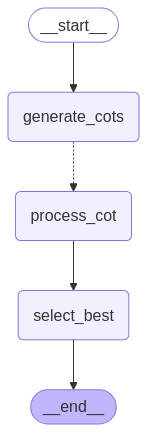

In [222]:
rare = RARE(retriever)
from IPython.display import Image, display

try:
    display(Image(rare.graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [239]:
rare = RARE(retriever)
rare.run("Am I eligible for UC SHIP if I've graduated?")

Saved: Am I eligible for UC SHIP if I've graduated?


{'question': "Am I eligible for UC SHIP if I've graduated?",
 'answer': 'Yes, if you have recently graduated and had UC SHIP coverage during your last quarter as a student, you are eligible to continue being covered by UC SHIP for one additional quarter after graduation. This coverage will last until the start of the next academic calendar year. To enroll and purchase this continuation coverage, you will need to complete the Continuation Voluntary Enrollment forms. It is important to note that graduates who opt out of UC SHIP fees will not be eligible for the UC Health Insurance Grant. Additionally, graduates have the option to waive UC SHIP fees if they prefer to use their own insurance plan, but they must submit a waiver each academic year. If you have any specific questions or need clarification on your eligibility for UC SHIP post-graduation, it is recommended to contact the UC SHIP administration or the relevant university department for further guidance.',
 'docs': ['Accept or wa

In [224]:
for i, row in df.iterrows():
    q = row["questions"]
    a = row["answers"]
    print(f"Processing Q{i+1}: {q}")
    src_ans_list.append(a)
    rare.run(q)

Processing Q1: Who can be a member of the Boating Club?
Saved: Who can be a member of the Boating Club?
Processing Q2: What classes does the boating center offer to community members?
Saved: What classes does the boating center offer to community members?
Processing Q3: When is the boating club open?
Saved: When is the boating club open?
Processing Q4: What boats are available to members?
Saved: What boats are available to members?
Processing Q5: How much does a boating membership cost?
Saved: How much does a boating membership cost?
Processing Q6: How do I sign up for a boating membership?
Saved: How do I sign up for a boating membership?
Processing Q7: How can I join the Boating Club?
Saved: How can I join the Boating Club?
Processing Q8: Are there additional fees to take out the boats after I join the boating club?
Saved: Are there additional fees to take out the boats after I join the boating club?
Processing Q9: Do the boating club rent Kayaks?
Saved: Do the boating club rent Kaya

In [233]:
len(gen_ans_list) , len(searched_docs)

(112, 112)

In [231]:
gen_ans_list[0], question_list[0], 

('The UC Santa Cruz Community Boating Center offers a variety of classes for community members interested in sailing, rowing, and kayaking. These classes cater to individuals of all skill levels, from beginners to experienced sailors and rowers. They provide opportunities to improve skills, build confidence on the water, and enjoy recreational boating activities in a safe and supportive environment. Additionally, the boating center offers access to a diverse fleet of sailing and rowing vessels for use during designated club hours. Members must be approved for boat use, and classes are available for those who need to enhance their on-water skills. Overall, the boating center serves as a valuable resource for individuals looking to explore the beauty of Monterey Bay through various boating classes and programs.',
 'What classes does the boating center offer to community members?')

In [ ]:
question_list[0]

In [232]:
del searched_docs[0]
del gen_ans_list[0]

In [234]:
import re

fallback_pattern = re.compile(
    r"Sorry, I couldn't find an exact answer\. Please check the UCSC website", re.IGNORECASE
)

# Get indices where the generated answer is NOT a fallback
valid_indices = [i for i, ans in enumerate(gen_ans_list) if not fallback_pattern.search(ans)]

# Filter all 4 lists using those indices
question_list = [question_list[i] for i in valid_indices]
src_ans_list = [src_ans_list[i] for i in valid_indices]
gen_ans_list = [gen_ans_list[i] for i in valid_indices]
searched_docs = [searched_docs[i] for i in valid_indices]


In [236]:
len(gen_ans_list) , len(searched_docs), len(src_ans_list), len(question_list)

(112, 112, 112, 112)

In [210]:

ragas_dataset = Dataset.from_dict({
    "question": question_list,
    "ground_truth": src_ans_list,
    "answer": gen_ans_list,
    "retrieved_contexts": searched_docs
})

metrics = [faithfulness, answer_relevancy, context_recall, context_precision]

results = evaluate(ragas_dataset, metrics=metrics, raise_exceptions=False)
print(results.to_pandas())


Evaluating: 100%|█████████████████████████████| 448/448 [08:08<00:00,  1.09s/it]


                                            user_input  \
0             Who can be a member of the Boating Club?   
1    What classes does the boating center offer to ...   
2                       When is the boating club open?   
3                 What boats are available to members?   
4             How much does a boating membership cost?   
..                                                 ...   
107  What if I don't fulfill the general education ...   
108                                    What is UC TAP?   
109              When are acceptance notices sent out?   
110  What are the Cross-Campus and Simultaneous Enr...   
111    Can I talk to an adviser during a campus visit?   

                                    retrieved_contexts  \
0    [How can I join the Boating Club?, The boating...   
1    [UC Santa Cruz Community Boating Center is a c...   
2    [Our club exists to give community members, UC...   
3    [Our club exists to give community members, UC...   
4    [The boa

In [211]:
resultsDF = results.to_pandas()
average_scores = resultsDF[['faithfulness', 'answer_relevancy', 'context_recall', 'context_precision']].mean()

# Display the average scores
print("Average Scores:")
print(average_scores)

Average Scores:
faithfulness         0.726902
answer_relevancy     0.670923
context_recall       0.580944
context_precision    0.444957
dtype: float64


In [ ]:
!pip install tavily-python

In [ ]:
!pip install --upgrade pip

In [245]:
!pip install -qU langchain-tavily

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [246]:
from langchain_tavily import TavilySearch

tavily_search = TavilySearch(
    max_results=5,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True
)


In [252]:
from typing import List, Annotated, TypedDict
import operator
import re
from langgraph.graph import StateGraph, START, END
from langgraph.constants import Send
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage



question_list = []
gen_ans_list = []
searched_docs = []
src_ans_list = [] 


class RAREState(TypedDict):
    query: str
    cot_candidates: Annotated[List[str], operator.add]
    refined_answers: Annotated[List[str], operator.add]
    supporting_docs: Annotated[List[List[str]], operator.add]
    best_answer: str
    best_docs: List[str]

class RARE:
    def __init__(self, retriever):
        self.llm = ChatOpenAI(temperature=0.7, model_name="gpt-3.5-turbo")
        self.retriever = retriever
        self.workflow = StateGraph(RAREState)
        self.num_agents = 3
        self.setup_workflow()

    def setup_workflow(self):
        self.workflow.add_node("generate_cots", self.generate_multiple_cots)
        self.workflow.add_node("process_cot", self.process_cot)
        self.workflow.add_node("select_best", self.select_best_answer)

        self.workflow.add_edge(START, "generate_cots")
        self.workflow.add_conditional_edges("generate_cots", self.dispatch_agents, ["process_cot"])
        self.workflow.add_edge("process_cot", "select_best")
        self.workflow.add_edge("select_best", END)

        self.graph = self.workflow.compile()

    def generate_multiple_cots(self, state: RAREState) -> dict:
        base_prompt = (
            f"Query: {state['query']}\n\n"
            "As an independent reasoning agent, devise a multi-step chain-of-thought to answer this question.\n"
            "Structure your output as a numbered list of steps."
        )
        cot_variants = []
        for i in range(self.num_agents):
            perspective = ["focus on academic aspects", "focus on student experience", "focus on logistics and policies"][i % 3]
            prompt = (
                f"You are agent #{i+1}. {base_prompt}\n"
                f"Try to approach the question differently by emphasizing: {perspective}."
            )
            response = self.llm.invoke([HumanMessage(content=prompt)])
            cot_variants.append(response.content.strip())

        return {"cot_candidates": cot_variants, "refined_answers": [], "supporting_docs": []}

    def dispatch_agents(self, state: RAREState):
        return [Send("process_cot", {"cot": cot}) for cot in state["cot_candidates"]]

    def process_cot(self, state: dict) -> dict:
        cot = state["cot"]
        steps = [s.strip() for s in cot.split("\n") if s.strip()]
        all_docs = []
        answers_per_step = []

        for step in steps:
            # Generate query for the step
            step_query_prompt = (
                f"For the reasoning step: '{step}', generate a concise query to retrieve relevant information.\n"
                "Include keywords like 'UCSC' or 'University of California Santa Cruz' if relevant."
            )
            query_msg = self.llm.invoke([HumanMessage(content=step_query_prompt)])
            query = query_msg.content.strip()

            docs = self.retriever.invoke(query)
            retrieved_texts = [doc.page_content for doc in docs]
            all_docs.extend(retrieved_texts)

            #  # Retrieve additional documents using Tavily
            # tavily_results = tavily_search.invoke(query)
            # for doc_text in tavily_results:
            #     if isinstance(doc_text, str) and doc_text.strip():
            #         retrieved_texts.append(doc_text)
            #         all_docs.append(doc_text)
            # Retrieve additional documents using Tavily
            tavily_results = tavily_search.invoke(query)
            # If Tavily returned one big string, wrap it in a list so we don't iterate chars
            if isinstance(tavily_results, str):
                tavily_results = [tavily_results]
            
            for doc_text in tavily_results:
                if isinstance(doc_text, str) and doc_text.strip():
                    retrieved_texts.append(doc_text)
                    all_docs.append(doc_text)




            joined_docs = "\n".join(retrieved_texts)
            reasoning_prompt = (
                f"Reasoning step: '{step}'\n\nRetrieved Documents:\n{joined_docs}\n\n"
                "Now provide a one-paragraph answer or insight based on this step and context."
            )

            refined_msg = self.llm.invoke([HumanMessage(content=reasoning_prompt)])
            answers_per_step.append(refined_msg.content.strip())

        # Synthesize agent's final answer
        full_agent_answer = "\n".join(answers_per_step)
        return {
            "refined_answers": [full_agent_answer],
            "supporting_docs": [all_docs]
        }

    def select_best_answer(self, state: RAREState) -> dict:
        prompt = (
            "Below are multiple candidate answers to the user's question. Evaluate them for factual correctness, completeness, and clarity.\n"
            f"User Query: {state['query']}\n\n"
        )
        for i, ans in enumerate(state["refined_answers"]):
            prompt += f"Answer #{i+1}:\n{ans}\n\n"
        prompt += (
    "If NONE of the answers are relevant or meaningful for answering the query, return: Answer #0.\n"
    "Otherwise, pick the best among them and return it as: Answer #<number>.\n"
    "Return ONLY the number in that format. Do NOT include any explanations."
)

        response = self.llm.invoke([HumanMessage(content=prompt)])
        match = re.search(r"Answer #?(\d+)", response.content)
        answer_num = int(match.group(1)) if match else 0
        
        # Fallback only if selector LLM explicitly returns Answer #0
        if answer_num == 0:
            return {
                "best_answer": "Sorry, I couldn't find an exact answer. Please check the UCSC website for more information.",
                "best_docs": []
            }
        
        index = answer_num - 1


        # Summarize into final answer
        raw = state["refined_answers"][index]
        summary_prompt = (
    f"The following is an agent-generated draft based on retrieved reasoning steps:\n\n{raw}\n\n"
    f"Now, write a single complete answer to the query:\n'{state['query']}'\n\n"
    "If you don't have enough info, say:\n"
    "Avoid bullet points. Be fluent and detailed, as if explaining to a student."
)

        summary_msg = self.llm.invoke([HumanMessage(content=summary_prompt)])
        final_answer = summary_msg.content.strip()

        return {
            "best_answer": final_answer,
            "best_docs": state["supporting_docs"][index]
        }

    def run(self, query: str):
        global question_list, gen_ans_list, searched_docs

        initial_state = {
            "query": query,
            "cot_candidates": [],
            "refined_answers": [],
            "supporting_docs": [],
            "best_answer": "",
            "best_docs": []
        }

        final_state = None
        for output in self.graph.stream(initial_state):
            final_state = output

        select_output = final_state.get("select_best", {})
        best_answer = select_output.get("best_answer", "").strip()
        best_docs = select_output.get("best_docs", [])

        if best_answer and best_docs:
            question_list.append(query)
            gen_ans_list.append(best_answer)
            searched_docs.append(best_docs)
            print(f"Saved: {query}")
        else:
            print(f"Skipped (no answer): {query}")

        return {
            "question": query,
            "answer": best_answer,
            "docs": best_docs
        }


In [253]:
rare = RARE(retriever)
rare.run("Am I eligible for UC SHIP if I've graduated?")

Saved: Am I eligible for UC SHIP if I've graduated?


{'question': "Am I eligible for UC SHIP if I've graduated?",
 'answer': "If you have recently graduated from a University of California campus and had UC SHIP coverage in the previous quarter, you are eligible for one additional quarter of UC SHIP coverage until the start of the next academic calendar year. To enroll and purchase this extended coverage, you will need to complete the Continuation Voluntary Enrollment forms. It is important to note that UC SHIP is automatically enrolled for full and part-time undergraduate students unless they choose to waive it with proof of comparable health insurance coverage. Additionally, financial aid may cover the cost of UC SHIP for eligible students. If you have any doubts about your eligibility for UC SHIP as a recent graduate, it is recommended to contact the UC SHIP administrators or the university's student health services office for personalized assistance and clarification on your specific situation.",
 'docs': ['Our campus also awards the

In [259]:

question_list = []
gen_ans_list = []
searched_docs = []
src_ans_list = []


In [263]:
len(gen_ans_list), len(searched_docs), len(question_list) , len( src_ans_list)


(0, 0, 0, 0)

In [264]:

import pandas as pd

# Load the CSV
df = pd.read_csv("new_qa.csv")

# Display the first few rows
print(df.head(5))

   index                                          questions  \
0      0           Who can be a member of the Boating Club?   
1      1  What classes does the boating center offer to ...   
2      2                     When is the boating club open?   
3      3               What boats are available to members?   
4      4           How much does a boating membership cost?   

                                             answers  \
0  Everyone is welcome to join! If you do not hav...   
1  We offer all levels of sailing (dinghy and kee...   
2  The club is open year-round, Saturday and Sund...   
3  Sailing vessels for weekend use currently incl...   
4  UCSC Student Membership: $45\nNon-Student Quar...   

                    source_name                                        source  \
0  UCSC Boating Recreation FQAs  https://recreation.ucsc.edu/boating/faq.html   
1  UCSC Boating Recreation FQAs  https://recreation.ucsc.edu/boating/faq.html   
2  UCSC Boating Recreation FQAs  https://

In [265]:
for i, row in df.iterrows():
    q = row["questions"]
    a = row["answers"]
    print(f"Processing Q{i+1}: {q}")
    src_ans_list.append(a)
    rare.run(q)

Processing Q1: Who can be a member of the Boating Club?
Saved: Who can be a member of the Boating Club?
Processing Q2: What classes does the boating center offer to community members?
Saved: What classes does the boating center offer to community members?
Processing Q3: When is the boating club open?
Saved: When is the boating club open?
Processing Q4: What boats are available to members?
Saved: What boats are available to members?
Processing Q5: How much does a boating membership cost?
Saved: How much does a boating membership cost?
Processing Q6: How do I sign up for a boating membership?
Saved: How do I sign up for a boating membership?
Processing Q7: How can I join the Boating Club?
Saved: How can I join the Boating Club?
Processing Q8: Are there additional fees to take out the boats after I join the boating club?
Saved: Are there additional fees to take out the boats after I join the boating club?
Processing Q9: Do the boating club rent Kayaks?
Saved: Do the boating club rent Kaya

In [266]:
len(gen_ans_list), len(searched_docs), len(question_list) , len( src_ans_list)

(112, 112, 112, 112)

In [267]:


ragas_dataset = Dataset.from_dict({
    "question": question_list,
    "ground_truth": src_ans_list,
    "answer": gen_ans_list,
    "retrieved_contexts": searched_docs
})

metrics = [faithfulness, answer_relevancy, context_recall, context_precision]

results = evaluate(ragas_dataset, metrics=metrics, raise_exceptions=False)
print(results.to_pandas())


Evaluating: 100%|█████████████████████████████| 448/448 [10:56<00:00,  1.47s/it]


                                            user_input  \
0             Who can be a member of the Boating Club?   
1    What classes does the boating center offer to ...   
2                       When is the boating club open?   
3                 What boats are available to members?   
4             How much does a boating membership cost?   
..                                                 ...   
107  What if I don't fulfill the general education ...   
108                                    What is UC TAP?   
109              When are acceptance notices sent out?   
110  What are the Cross-Campus and Simultaneous Enr...   
111    Can I talk to an adviser during a campus visit?   

                                    retrieved_contexts  \
0    [The boating club exists to give community mem...   
1    [UC Santa Cruz Community Boating Center is a c...   
2    [The boating club exists to give community mem...   
3    [Member Registration & Club Information, Liste...   
4    [Club Me

In [268]:
resultsDF = results.to_pandas()
average_scores = resultsDF[['faithfulness', 'answer_relevancy', 'context_recall', 'context_precision']].mean()

# Display the average scores
print("Average Scores:")
print(average_scores)

Average Scores:
faithfulness         0.693092
answer_relevancy     0.666694
context_recall       0.671519
context_precision    0.347595
dtype: float64


In [ ]:
len(gen_ans_list), len(searched_docs), len(question_list) , len( src_ans_list)